In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
from pathlib import Path

# load data 

In [2]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False
)

batch_size_1=32
batch_size_2=16

train_dir = "./images/cleaned"
IMG_HEIGHT, IMG_WIDTH = 128, 128

train_data_gen_1 = train_image_generator.flow_from_directory(batch_size=batch_size_1,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
train_data_gen_2 = train_image_generator.flow_from_directory(batch_size=batch_size_2,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))



print(train_data_gen_1.class_indices)

Found 528 images belonging to 4 classes.
Found 528 images belonging to 4 classes.
{'Bier': 0, 'Cocktail': 1, 'Wasser': 2, 'Wein': 3}


## numbers for traininng

In [3]:
estimated_image_count = 600 #TODO count it
nr_samples = estimated_image_count
nr_epochs = 10 #TODO way more or early stop (see at training above)
steps_per_epoch_1 =  nr_samples / batch_size_1
steps_per_epoch_2 =  nr_samples / batch_size_2

## Utility function that will skip batches if there is a broken image in it

In [4]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

# display images

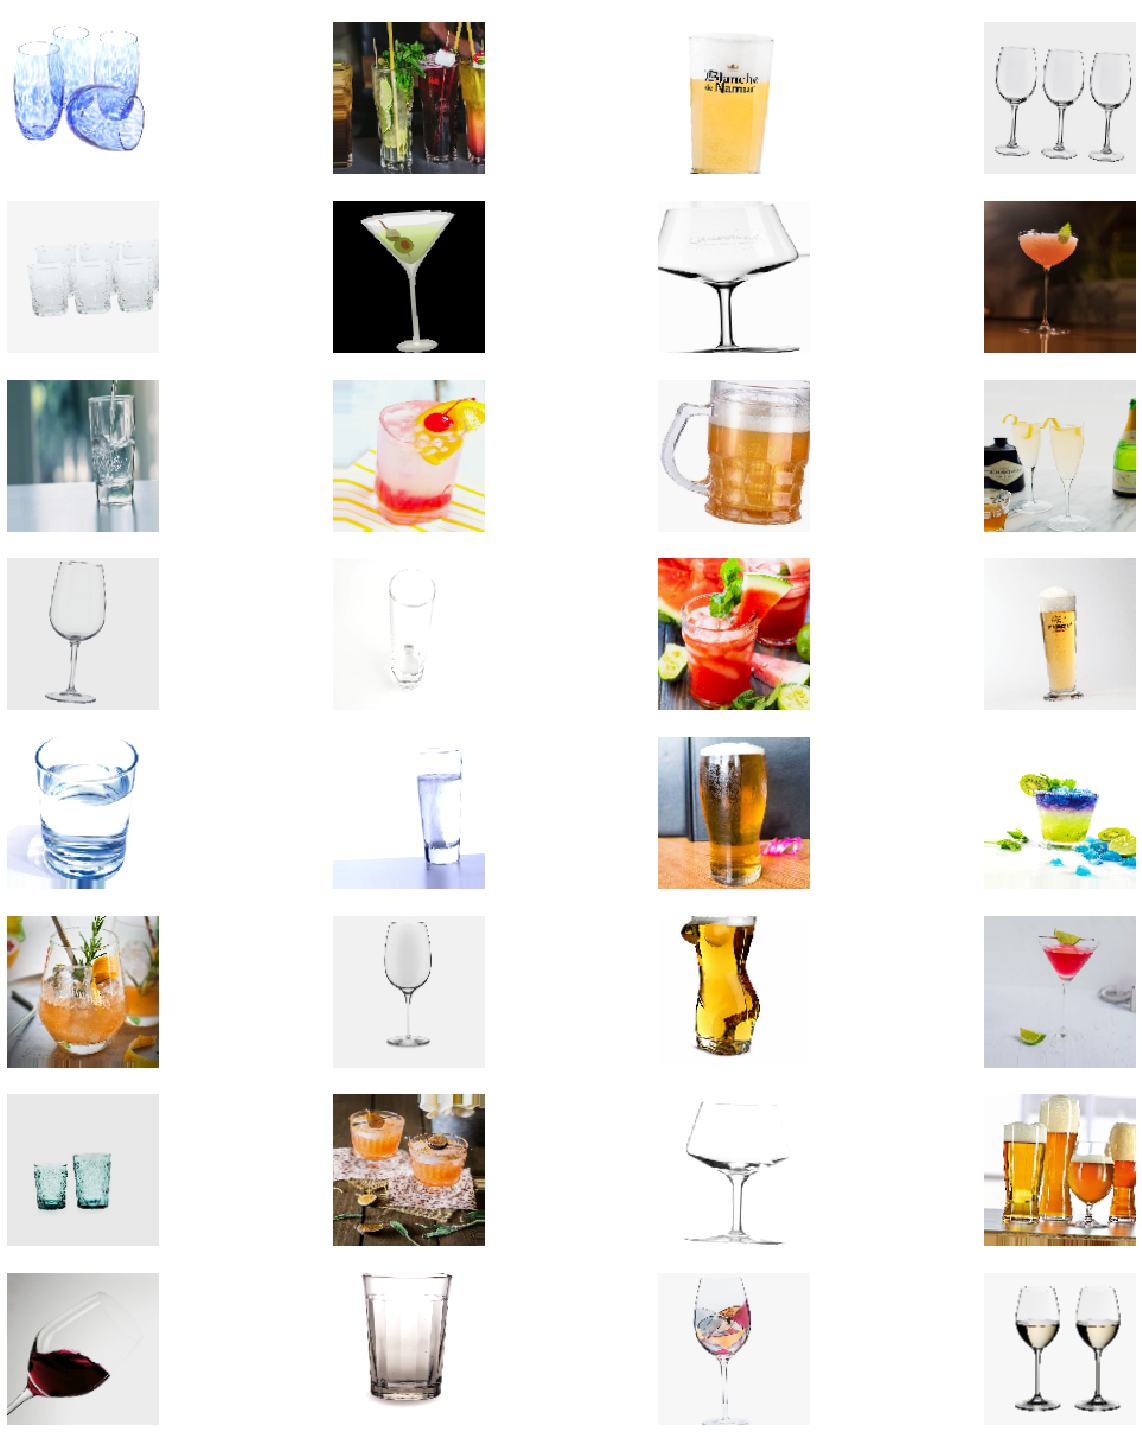

In [5]:
sample_training_images, labels = next(train_data_gen_1)
class_label = {v:k for k,v in train_data_gen_1.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Model 1

In [6]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen_1.num_classes, 'softmax')
])
    
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

# Model 2

In [7]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen_2.num_classes, 'softmax')
])
    
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

# Train models and save trained model

.warn(message)
34/37 [==========================>...] - ETA: 10s - loss: 0.2897 - categorical_accuracy: 0.9007C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
35/37 [===========================>..] - ETA: 7s - loss: 0.2885 - categorical_accuracy: 0.9018C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
36/37 [===========================>..] - ETA: 4s - loss: 0.2854 - categorical_accuracy: 0.9028C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
37/37 [============================>.] - ETA: 1s - loss: 0.2863 - categorical_accuracy: 0.9020C:\User

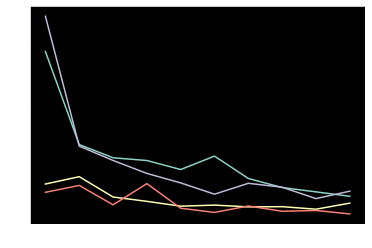

In [8]:
def train_model(model, data_gen, steps_per_epoch, file_name):
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

    history = model.fit_generator(
        skip_broken_images(data_gen),
        steps_per_epoch=steps_per_epoch, #use way more steps here: number of samples / batch size
        epochs=nr_epochs,# or EarlyStopping callback
        callbacks=[]
    )

    print(file_name)
    plt.plot(history.history['loss'])

    model.save(file_name)

train_model(model_1, train_data_gen_1, steps_per_epoch_1, 'drink-detection-model1-g1.h5')
train_model(model_1, train_data_gen_2, steps_per_epoch_2, 'drink-detection-model1-g2.h5')
train_model(model_2, train_data_gen_1, steps_per_epoch_1, 'drink-detection-model2-g1.h5')
train_model(model_2, train_data_gen_2, steps_per_epoch_2, 'drink-detection-model2-g2.h5')